Correction term to the frenkel-ladd free energy taken from Phase Transitions of Hard Spheres Plus Depletants; Basics by Lekkerkerker & Tuinier, Ch 3.3.2

In [1]:
import signac
import numpy as np
from matplotlib import pyplot as plt
import os
import hoomd

In [2]:
hoomd.context.initialize("mode==cpu")

HOOMD-blue v2.6.0-8-g898f4c752 DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 06/06/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
project=signac.get_project()

In [4]:
project.root_directory()

'/scratch/sglotzer_fluxoe/plawton/transfercode/frenkel-ladd'

In [5]:
def read_log(job):
    pipe = np.genfromtxt(job.fn('calc_FL.log'), names=True)
    
    return np.log(pipe['lattice_translational_spring_constant'][::-1]), pipe['lattice_energy_pp_avg'][::-1]/pipe['lattice_translational_spring_constant'][::-1], pipe['lattice_energy_pp_sigma'][::-1]/pipe['lattice_translational_spring_constant'][::-1]

In [6]:
## per particle
def calc_FL(log_gamma, U, delU):
    avg_energies = []
    sigmas = []
    pos_gammas = []
    for i in range(0,len(log_gamma)):
        if log_gamma[i] > 0:
            avg_energies.append(U[i]*np.exp(log_gamma[i])) # multiply by factor of gamma bc integrating over log_gamma
            sigmas.append(delU[i]*np.exp(log_gamma[i]))
            pos_gammas.append(log_gamma[i])
    avg_energies = np.array(avg_energies)
    sigmas = np.array(sigmas)
    pos_gammas = np.array(pos_gammas)
    return np.trapz(avg_energies, pos_gammas), np.trapz(sigmas, pos_gammas)

In [16]:
job = signac.get_job(project.root_directory() + "/workspace/0068fc4cc84932cacdc5150340d01692/")
# job.document["free_volume"] = job.document.pop("free_volumes")
gsd = (job.fn('calc_FL.gsd'))
snap = hoomd.data.gsd_snapshot(gsd)

In [17]:
job.document

{'N': 512, 'valid_pf': True, 'random_seed': 88074, 'steps_completed': 9240421, 'gamma_completed': -5.0, 'completed': True, 'delA': 35.04646018764934, 'delA_err': 0.8981048298852193, 'free_volume': 203.4275787755102, 'delA_corrected': -147930669.6079878}

In [6]:
### Getting depletant number density
Vc = (3/4)*((900)**3)*np.pi*(1e-21) # ml per colloid particle
n_d = 7.2e15 # depletant particle per ml
N_c = snap.particles.N # number of colloidal particles
Nd = Vc*n_d*N_c # number of depletant particles
vol = snap.box.Lx*snap.box.Ly*snap.box.Lz
n_d_sim = Nd/vol
n_d_sim

7271.910010672394

In [8]:
n_c_sim = N_c/vol # colloidal number density in simulation
n_c_exp = 1 / Vc # colloidal number density in experiment
n_d_sim = n_d * n_c_sim / n_c_exp
n_d_sim

7271.9100106723945

In [59]:
job = signac.get_job(project.root_directory() + "/workspace/836404f3cd8383358b2cd28785dbc46f/")
job.document

{'N': 512, 'valid_pf': True, 'random_seed': 58994, 'delA': 34.60243269766078, 'delA_err': 0.8974953636912499, 'steps_completed': 9240421, 'gamma_completed': -5.0, 'completed': True, 'free_volume': 241.77485913043472}

In [21]:
print (project.detect_schema()['truncation'])
# project.read_statepoints()
# type(project.detect_schema())
print (project.detect_schema().keys())

defaultdict(<class 'set'>, {<class 'float'>: {0.53, 0.49, 0.51, 0.71, 0.75, 0.61, 0.83, 0.59, 0.63, 0.73, 0.79, 0.69, 0.57, 0.81, 0.67, 0.77, 0.65, 0.47, 0.55}})
dict_keys([('structure',), ('pf',), ('truncation',)])


In [7]:
truncations = sorted([0.53, 0.49, 0.51, 0.71, 
        0.75, 0.61, 0.83, 0.59, 
        0.63, 0.73, 0.79, 0.69, 
        0.57, 0.81, 0.67, 0.77, 
        0.65, 0.47, 0.55])
cd_pfs = [0.56, 0.57, 0.6, 0.59, 0.57, 
                   0.55, 0.55, 0.55, 0.55, 0.55, 
                   0.55, 0.55, 0.56, 0.57, 0.58,
                   0.59, 0.6, 0.6, 0.61]
cd_pfs = dict(zip(truncations, cd_pfs))

In [9]:
### add energy differences with free volume correction and errors to job document
Vc = (3/4)*((900)**3)*np.pi*(1e-21) # ml per colloid particle
n_d_exp = 7.2e15 # depletant particle per ml used in experiment
for job in project:
    if os.path.exists(job.fn('calc_FL.log'))==True:
        data = read_log(job)
        job.document['delA'],job.document['delA_err']=calc_FL(*data) 
        
        # calculate depletant number density for use in fv correction
        gsd = (job.fn('calc_FL.gsd'))
        snap = hoomd.data.gsd_snapshot(gsd)
        N_c = snap.particles.N # number of colloidal particles
        vol = snap.box.Lx*snap.box.Ly*snap.box.Lz
        n_c_sim = N_c / vol # number density of simulation colloids
#         n_c_exp = (1/Vc) * cd_pfs[job.sp['truncation']] # exp colloidal num density, 
#                                                         # using pf values from Damasceno 2012
        n_c_exp = (1/Vc) * 0.01
        n_d_sim = (n_d_exp / n_c_exp) * n_c_sim # ratio of depletant to colloid num densities is the same 
                                                # between simulation and experiment
        ### old way ###
#         Nd = Vc*n_d*N_c # number of depletant particles
#         n_d_sim = Nd/vol # depletant number density for given simulation
        ### old way ###
    
        # get fv correction and add corrected delA to job document 
        kT = 1 #hpmc
        P_R = n_d_sim * kT# osmotic pressure of depletants in reservoir 
        job.document['delA_corrected'] = job.document['delA'] - job.document['free_volume'] * P_R

In [7]:
n_d_sim

12193.618010436528

In [45]:
print("The number of unique truncation values being used is",
      len(np.unique([job.sp['truncation'] for job in project.find_jobs({"structure":"hexagonaldiamond"})])))

The number of unique truncation values being used is 19


## uncorrected free energies

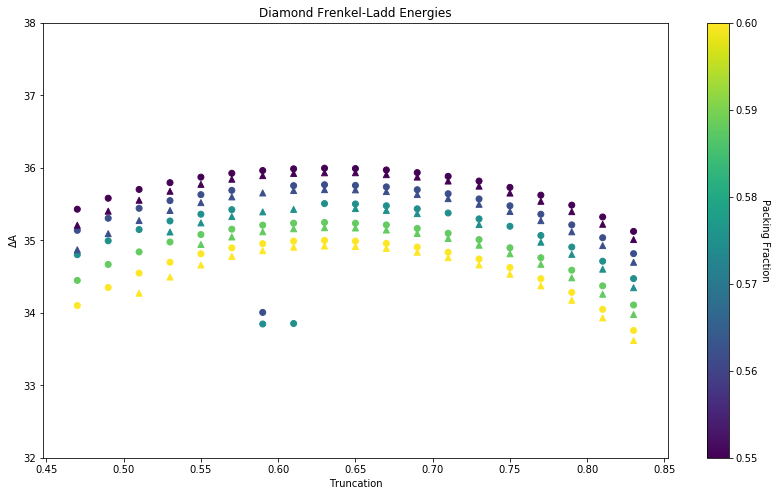

In [64]:
markers = {'hexagonaldiamond':'^', 'cubicdiamond':'o'}
fig, ax = plt.subplots(figsize=(14,8))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['structure', 'pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    arr = [job.document['delA'] for job in jobs]
    x_arr = [job.sp['truncation'] for job in jobs]
    err = [job.document['delA_err'] for job in jobs]
#     error = ax.errorbar(x_arr, arr, yerr=err, ls='', color='red', alpha=0.3)
    im = ax.scatter(x_arr, arr, c=np.ones_like(x_arr)*key[1], marker=markers[key[0]], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
#     pyplot.figure(figsize=(20,10))
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
# plt.ylim(0.2,0.4)
plt.ylim(32,38)
plt.xlabel('Truncation')
plt.ylabel(r'$\Delta$A')
plt.title('Diamond Frenkel-Ladd Energies')
plt.show()

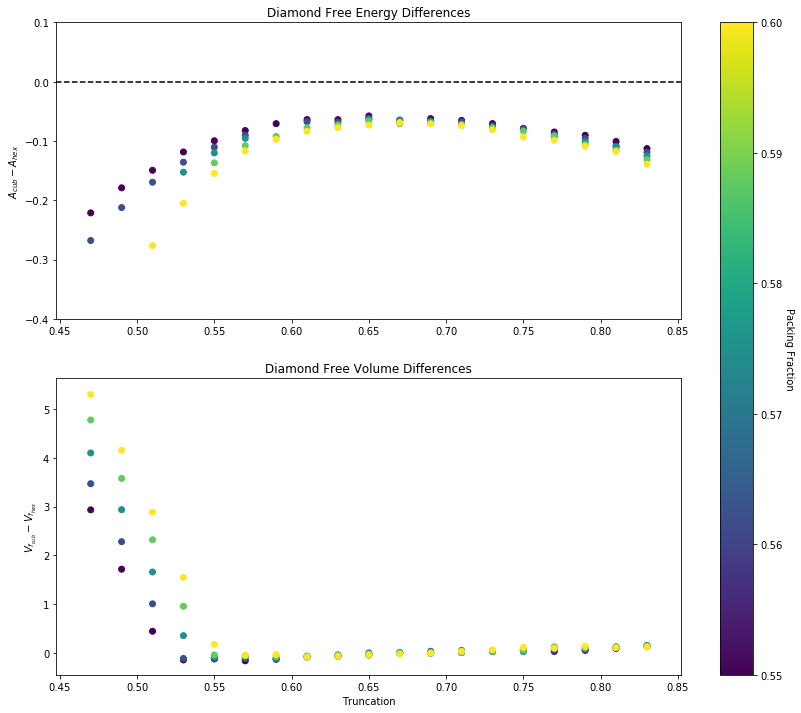

In [41]:
fig, ax = plt.subplots(2,figsize=(14,12))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    x_arr = np.unique([job.sp['truncation'] for job in jobs])
    hex_A = []
    hex_Vf = []
    cub_A = []
    cub_Vf = []
    for job in jobs:
        if job.sp['structure'] == 'hexagonaldiamond':
            hex_A.append(job.document['delA'])
            hex_Vf.append(job.document['free_volume'])
        if job.sp['structure'] == 'cubicdiamond':
            cub_A.append(job.document['delA'])
            cub_Vf.append(job.document['free_volume'])
    diff = np.array(hex_A) - np.array(cub_A)
    Vf_diff = np.array(hex_Vf) - np.array(cub_Vf)
    im = ax[0].scatter(x_arr, diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
    im = ax[1].scatter(x_arr, Vf_diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
#     break
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
plt.xlabel('Truncation')
ax[0].set(ylabel=r'$A_{cub}-A_{hex}$')
ax[0].set(title='Diamond Free Energy Differences')
ax[0].axhline(0, ls='--', color='black')
ax[0].set_ylim([-0.4,0.1])
ax[1].set(ylabel=r'$V_{f_{cub}}-V_{f_{hex}}$')
ax[1].set(title='Diamond Free Volume Differences')
# plt.axvline(0.51, ls='--', color='black', alpha=0.6)
# plt.axvline(0.73, ls='--', color='black', alpha=0.6)
plt.show()

## corrected free energies

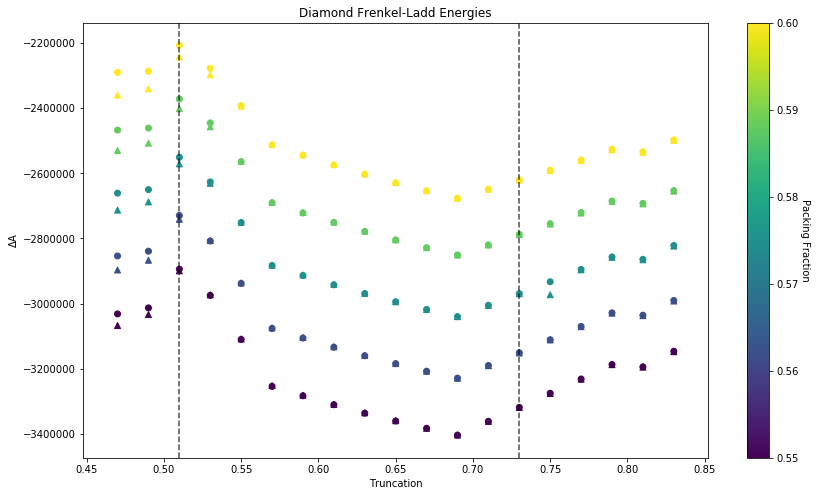

In [66]:
markers = {'hexagonaldiamond':'^', 'cubicdiamond':'o'}
fig, ax = plt.subplots(figsize=(14,8))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['structure', 'pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    arr = [job.document['delA_corrected'] for job in jobs]
    x_arr = [job.sp['truncation'] for job in jobs]
    err = [job.document['delA_err'] for job in jobs]
#     error = ax.errorbar(x_arr, arr, yerr=err, ls='', color='red', alpha=0.3)
    im = ax.scatter(x_arr, arr, c=np.ones_like(x_arr)*key[1], marker=markers[key[0]], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
#     pyplot.figure(figsize=(20,10))
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
plt.axvline(0.51, ls='--', color='black', alpha=0.7)
plt.axvline(0.73, ls='--', color='black', alpha=0.7)
# plt.ylim(0.2,0.4)
# plt.ylim(30,40)
plt.xlabel('Truncation')
plt.ylabel(r'$\Delta$A')
plt.title('Diamond Frenkel-Ladd Energies')
plt.show()

In [50]:
cd_pfs

{0.47: 0.56,
 0.49: 0.57,
 0.51: 0.6,
 0.53: 0.59,
 0.55: 0.57,
 0.57: 0.55,
 0.59: 0.55,
 0.61: 0.55,
 0.63: 0.55,
 0.65: 0.55,
 0.67: 0.55,
 0.69: 0.55,
 0.71: 0.56,
 0.73: 0.57,
 0.75: 0.58,
 0.77: 0.59,
 0.79: 0.6,
 0.81: 0.6,
 0.83: 0.61}

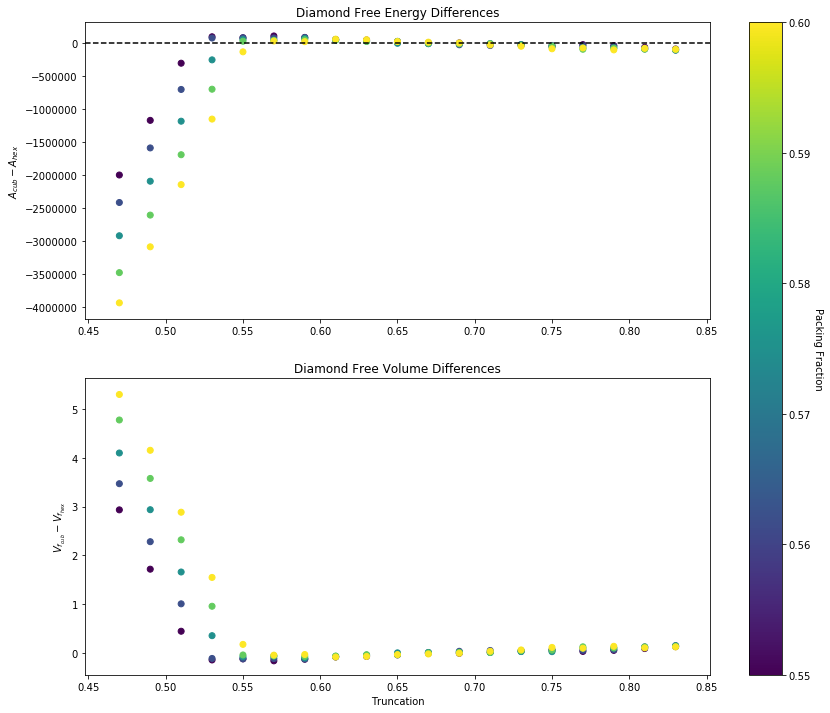

In [30]:
fig, ax = plt.subplots(2,figsize=(14,12))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    x_arr = np.unique([job.sp['truncation'] for job in jobs])
    hex_A = []
    hex_Vf = []
    cub_A = []
    cub_Vf = []
    for job in jobs:
        if job.sp['structure'] == 'hexagonaldiamond':
            hex_A.append(job.document['delA_corrected'])
            hex_Vf.append(job.document['free_volume'])
        if job.sp['structure'] == 'cubicdiamond':
            cub_A.append(job.document['delA_corrected'])
            cub_Vf.append(job.document['free_volume'])
    diff = np.array(hex_A) - np.array(cub_A)
    Vf_diff = np.array(hex_Vf) - np.array(cub_Vf)
    im = ax[0].scatter(x_arr, diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
    im = ax[1].scatter(x_arr, Vf_diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
#     break
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
plt.xlabel('Truncation')
ax[0].set(ylabel=r'$A_{cub}-A_{hex}$')
ax[0].set(title='Diamond Free Energy Differences')
ax[0].axhline(0, ls='--', color='black')
ax[1].set(ylabel=r'$V_{f_{cub}}-V_{f_{hex}}$')
ax[1].set(title='Diamond Free Volume Differences')
# plt.ylim(-1200,1500)
# plt.ylim(-0.02,0.02)
plt.show()

In [53]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

In [55]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

In [58]:
I.shape

(1000, 1000)

In [76]:
c = np.random.random(50)
c

array([0.57650527, 0.34355397, 0.39766419, 0.97816269, 0.97336611,
       0.12282544, 0.12693253, 0.57097457, 0.07671138, 0.55575785,
       0.21858808, 0.59527283, 0.45944787, 0.69588757, 0.66221212,
       0.98346973, 0.34169371, 0.76714452, 0.86762727, 0.18135912,
       0.22841083, 0.85930065, 0.57571892, 0.57052977, 0.5725855 ,
       0.42635887, 0.41829012, 0.48446783, 0.27419543, 0.90831788,
       0.73845048, 0.59554988, 0.35980961, 0.8758435 , 0.34836565,
       0.64107881, 0.99044745, 0.74300062, 0.60625501, 0.58864287,
       0.17240611, 0.64373539, 0.14201248, 0.211956  , 0.57738707,
       0.40945657, 0.16217669, 0.82552209, 0.81396158, 0.58651656])

## Plotting free volume differences

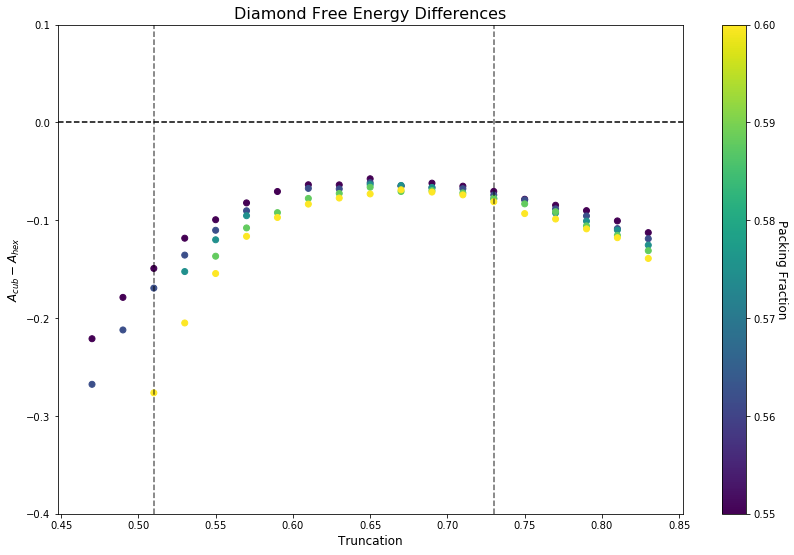

In [76]:
fig, ax = plt.subplots(figsize=(14,9))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    x_arr = np.unique([job.sp['truncation'] for job in jobs])
    hex_A = []
    cub_A = []
    for job in jobs:
        if job.sp['structure'] == 'hexagonaldiamond':
            hex_A.append(job.document['delA'])
        if job.sp['structure'] == 'cubicdiamond':
            cub_A.append(job.document['delA'])
    diff = np.array(hex_A) - np.array(cub_A)
    im = ax.scatter(x_arr, diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
#     break
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270, fontsize=12)
plt.xlabel('Truncation', fontsize=12)
plt.ylabel(r'$A_{cub}-A_{hex}$', fontsize=12)
plt.title('Diamond Free Energy Differences', fontsize=16)
plt.axhline(0, ls='--', color='black')
# plt.axvline(0.51, ls='--', color='black', alpha=0.6)
# plt.axvline(0.73, ls='--', color='black', alpha=0.6)
plt.ylim(-0.4,0.1)
# plt.ylim(-0.02,0.02)
plt.show()

### Vyas' Code

In [50]:
# data = np.genfromtxt(filename, names=True)
for job in project:
#     print (job.get_id())
    if os.path.exists(job.fn('calc_FL.log'))==True:
        data = read_log(job)
        log_spring_constants = data[0]
        lattice_energy = data[1]*(np.array([10**x for x in log_spring_constants]))
        free_energy = np.trapz(lattice_energy[:-1], log_spring_constants[:-1])
        job.document['delA'] = free_energy 
        

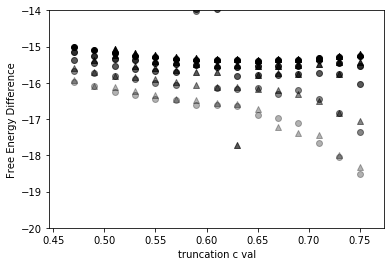

In [52]:
markers = {'hexagonaldiamond':'^', 'cubicdiamond':'o'}
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['structure', 'pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    arr = [job.document['delA'] for job in jobs]
    x_arr = [job.sp['truncation'] for job in jobs]
    pyplot.scatter(x_arr, arr, color='black', marker=markers[key[0]], alpha=shades[key[1]])
#     pyplot.figure(figsize=(20,10))
pyplot.ylim(-20,-14)
pyplot.xlabel('truncation c val')
pyplot.ylabel('Free Energy Difference')
pyplot.show()